# SMBO

In [2]:
import numpy as np

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
MIN = -5.12
MAX = 5.12
D = 1
Ds = [3, 5, 10]
BATCH_SIZE = 100
ITERATIONS = 500
FOREST_SIZE = 10
NEXT_SAMPLE_SIZE = 5

In [4]:
import math

def rastrigin(X, A = 10):
    res = 0
    for x_i in X:
        res += A + x_i**2 - A*np.cos(2 * math.pi * x_i)
    return res

In [5]:
def random_args(N):
    return np.random.rand(N) * (MAX - MIN) + MIN

def rand_batch():
    return np.array([random_args(D) for i in range(BATCH_SIZE)])

In [6]:
from functools import reduce

def min_rastrigin(batch):
    return reduce(min, map(rastrigin, batch))

In [7]:
def random_rastrigin_opt():
    result = np.empty([ITERATIONS], float)
    for i in range(ITERATIONS):
        batch = rand_batch()
        min_val = min_rastrigin(batch)
        if i == 0:
            result[i] = min_val
        else:
            result[i] = min(result[i-1], min_val)
    return result

In [8]:
from sklearn.tree import DecisionTreeRegressor

def random_forest_rastrigin_opt():
    current = rand_batch()
    forest = np.array([DecisionTreeRegressor() for i in range(FOREST_SIZE)])
    result = np.empty([ITERATIONS], float)
    
    print("RF:")
    for i in range(ITERATIONS):
        if i % 100 == 0:
            print("Iteration: ", i)
            
        y_current = np.array(list(map(rastrigin, current)))
        current_size = current.shape[0]
        
        for j in range(FOREST_SIZE):
            indices = np.random.choice(current_size, current_size)
            forest[j].fit(current[indices], y_current[indices])
            
        next_batch = rand_batch()
        y_predict = np.empty([FOREST_SIZE, BATCH_SIZE], dtype=float)
        
        for j in range(FOREST_SIZE):
            y_predict[j] = forest[j].predict(next_batch)
            
        means = y_predict.mean(axis=0)
        variances = y_predict.var(axis=0)
        poi = (variances-variances.mean())/means
        next_indices = np.argsort(poi)[-NEXT_SAMPLE_SIZE:]
        current = np.concatenate((current, next_batch[next_indices]))
        min_val = min_rastrigin(next_batch[next_indices])
                
        if (i == 0):
            result[i] = min_val
        else:
            result[i] = min(result[i-1], min_val)
        
    return result

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor

def gaussian_process_rastrigin_opt():
    gpr = GaussianProcessRegressor()
    current = rand_batch()
    result = np.empty([ITERATIONS], float)
    
    print("GP:")
    for i in range(ITERATIONS):
        if i % 100 == 0:
            print("Iteration: ", i)
            
        y_current = np.array(list(map(rastrigin, current)))
        gpr.fit(current, y_current)
                
        next_batch = rand_batch()
        
        means, stds = gpr.predict(next_batch, return_std=True)
        variances = stds ** 2
        poi = (variances-variances.mean())/means
        next_indices = np.argsort(poi)[:NEXT_SAMPLE_SIZE]
        current = np.concatenate((current, next_batch[next_indices]))
        min_val = min_rastrigin(next_batch[next_indices])
                
        if (i == 0):
            result[i] = min_val
        else:
            result[i] = min(result[i-1], min_val)
        
    return result

RF:
Iteration:  0
Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400
GP:
Iteration:  0
Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400
RF:
Iteration:  0
Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400
GP:
Iteration:  0
Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400
RF:
Iteration:  0
Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400
GP:
Iteration:  0
Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400


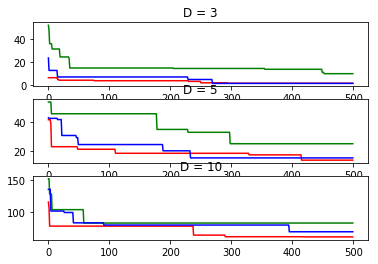

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

iters = range(ITERATIONS)
results = np.empty([3, len(Ds), ITERATIONS])

for counter, value in enumerate(Ds):
    D = value
    
    results[0, counter] = random_rastrigin_opt()
    results[1, counter] = random_forest_rastrigin_opt()
    results[2, counter] = gaussian_process_rastrigin_opt()

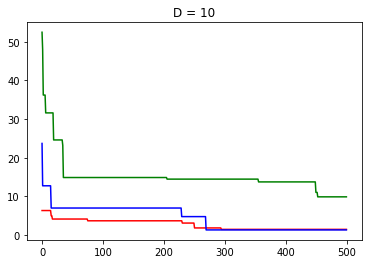

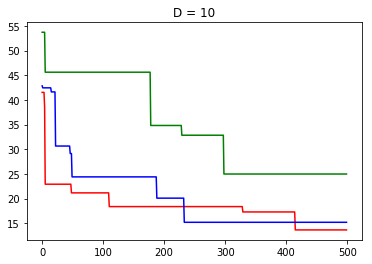

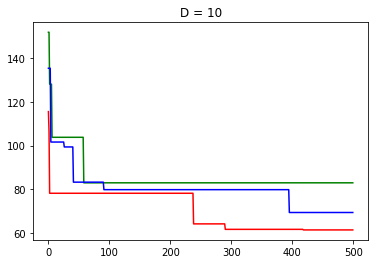

In [13]:
for counter, _ in enumerate(Ds):
    plt.figure(counter+1)
    plt.title('D = ' + str(value))
    plt.plot(iters, results[0, counter], color='r')
    plt.plot(iters, results[1, counter], color='g')
    plt.plot(iters, results[2, counter], color='b')
    
plt.show()